## Подключитесь к базе. Загрузите таблицы sql

In [1]:
!pip install imbalanced-learn -q
!pip install phik -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

# Phik correlation
import phik
from phik.report import plot_correlation_matrix

# Scikit-learn imports
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score,\
precision_recall_curve, auc

Конфигурация подключения к базе данных:

In [3]:
db_config = {
    'user': 'praktikum_student',
    'password': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'database': 'data-science-vehicle-db'
}

Создание строки подключения и подключения к базе данных:

In [4]:
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

Проверка наличия таблиц в базе данных:

In [5]:
# Список таблиц, которые нужно проверить
tables_to_check = ['collisions', 'parties', 'vehicles']

Проверка наличия нужных таблиц и вывод информации о их колонках:

In [6]:
for table_name in tables_to_check:
    # Проверка наличия таблицы
    query = f"""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public'
    AND table_name = '{table_name}';
    """
    result_df = pd.read_sql(query, engine)
    
    if not result_df.empty:
        print(f"\nТаблица '{table_name}' существует в базе данных.\n")
        
        # Получение информации о столбцах таблицы
        query = f"""
        SELECT column_name, data_type
        FROM information_schema.columns
        WHERE table_name = '{table_name}';
        """
        columns_df = pd.read_sql(query, engine)
        
        # Выводим информацию о столбцах
        print(f"Столбцы таблицы '{table_name}':\n")
        display(columns_df)
    
    else:
        print(f"Таблица '{table_name}' не найдена в базе данных.")


Таблица 'collisions' существует в базе данных.

Столбцы таблицы 'collisions':



,column_name,data_type
0,party_count,integer
1,intersection,integer
2,distance,real
3,collision_date,date
4,collision_time,time without time zone
5,location_type,text
6,collision_damage,text
7,case_id,text
8,pcf_violation_category,text
9,type_of_collision,text



Таблица 'parties' существует в базе данных.

Столбцы таблицы 'parties':



,column_name,data_type
0,cellphone_in_use,integer
1,party_number,integer
2,at_fault,integer
3,insurance_premium,integer
4,id,integer
5,case_id,text
6,party_drug_physical,text
7,party_type,text
8,party_sobriety,text



Таблица 'vehicles' существует в базе данных.

Столбцы таблицы 'vehicles':



,column_name,data_type
0,id,integer
1,party_number,integer
2,vehicle_age,integer
3,case_id,text
4,vehicle_type,text
5,vehicle_transmission,text


In [7]:
for table_name in tables_to_check:
    print(f"\nПервые 10 строк из таблицы '{table_name}':")
    
    # SQL-запрос для получения первых 10 строк
    query = f"SELECT * FROM {table_name} LIMIT 10;"
    
    # Выполнение запроса и присваивание в переменную с динамическим именем
    globals()[f"{table_name}_df"] = pd.read_sql(query, engine)
    
    # Вывод первых 10 строк
    display(globals()[f"{table_name}_df"])

# Закрытие соединения с базой данных
engine.dispose()


Первые 10 строк из таблицы 'collisions':


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00



Первые 10 строк из таблицы 'parties':


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN



Первые 10 строк из таблицы 'vehicles':


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


## Проведите первичное исследование таблиц

In [8]:
# Первичное исследование таблиц
collisions_df.info()
parties_df.info()
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      10 non-null     object 
 1   county_city_location         10 non-null     object 
 2   county_location              10 non-null     object 
 3   distance                     10 non-null     float64
 4   direction                    4 non-null      object 
 5   intersection                 10 non-null     int64  
 6   weather_1                    10 non-null     object 
 7   location_type                5 non-null      object 
 8   collision_damage             10 non-null     object 
 9   party_count                  10 non-null     int64  
 10  primary_collision_factor     10 non-null     object 
 11  pcf_violation_category       9 non-null      object 
 12  type_of_collision            10 non-null     object 
 13  motor_vehicle_involved_

Присутствуют пропуски в нескольких столбцах, особенно в таблицах `collisions` и `parties`.

Столбцы `collision_date` и `collision_time` в таблице `collisions` представлены в виде строк. Для дальнейшей работы с этими данными их можно преобразовать в типы `datetime` и `time` соответственно.

Во всех трех таблицах присутствует общий столбец `case_id`, который, играет роль идентификатора случая ДТП и будет использоваться для объединения данных из разных таблиц.

##  Проведите статистический анализ факторов ДТП

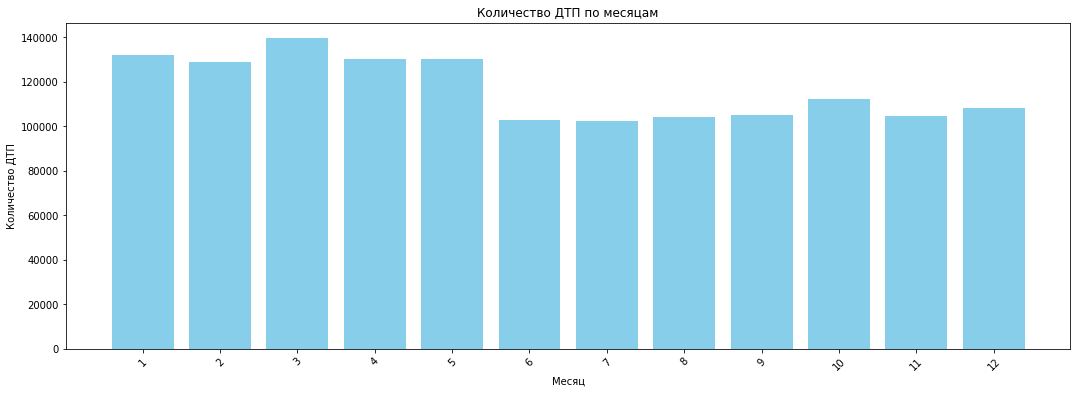

In [9]:
# Статистический анализ факторов ДТП по месяцам
query = """
SELECT EXTRACT(MONTH FROM collision_date) AS month, COUNT(*) AS accident_count
FROM collisions
GROUP BY month
ORDER BY month;
"""
accidents_by_month_df = pd.read_sql(query, engine)

# Построение графика количества ДТП по месяцам
plt.figure(figsize=(18, 6))
plt.bar(accidents_by_month_df['month'], accidents_by_month_df['accident_count'], color='skyblue')
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.title('Количество ДТП по месяцам')
plt.xticks(accidents_by_month_df['month'], rotation=45)
plt.show()

Первые 5 месяцев года (с января по май) оказываются самыми аварийными, это может быть связано с несколькими факторами, которые влияют на дорожную обстановку и поведение водителей в этот период:
- Скользкие дороги зимой
- Переходные погодные условия весной
- Рост активности на дорогах ближе к началу отпускного сезона

Видно, что наибольшее количество ДТП приходится на март. Это может быть связано с сочетанием переменчивых погодных условий, активизацией дорожного движения и ухудшением состояния дорог после зимы.

Задачи для аналитиков:

- Проанализируйте серьёзность повреждений транспортных средств в зависимости от состояния дороги.
- Найдите, как погодные условия влияют на количество ДТП.
- Проверьте, есть ли корреляция между возрастом автомобиля и вероятностью его участия в ДТП.
- Изучите зависимость между трезвостью водителя и его участием в ДТП.
- Исследуйте частоту использования мобильных телефонов водителями, причастными к ДТП.
- Найдите самые частые причины ДТП.

Решение двух задач:

Анализ количества ДТП в зависимости от состояния дороги и типа транспортного средства:

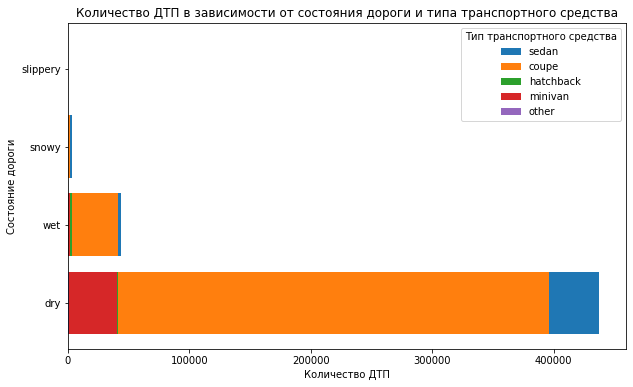

In [10]:
query = """
SELECT c.road_surface, v.vehicle_type, COUNT(*) AS accident_count
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
GROUP BY c.road_surface, v.vehicle_type
ORDER BY accident_count DESC;
"""
road_surface_df = pd.read_sql(query, engine)

# Удалим строки с пропусками
road_surface_df.dropna(subset=['road_surface', 'vehicle_type'], inplace=True)

# Построение графика
plt.figure(figsize=(10, 6))
for vehicle_type in road_surface_df['vehicle_type'].unique():
    df_subset = road_surface_df[road_surface_df['vehicle_type'] == vehicle_type]
    plt.barh(df_subset['road_surface'], df_subset['accident_count'], label=vehicle_type)

plt.xlabel('Количество ДТП')
plt.ylabel('Состояние дороги')
plt.title('Количество ДТП в зависимости от состояния дороги и типа транспортного средства')
plt.legend(title='Тип транспортного средства')
plt.show()

Основная масса ДТП происходит на сухой дороге, что свидетельствует о том, что благоприятные погодные условия не всегда гарантируют безопасность на дороге. Купе чаще попадают в аварии.

Анализ количества ДТП в зависимости от уровня трезвости водителя и тяжести повреждений:

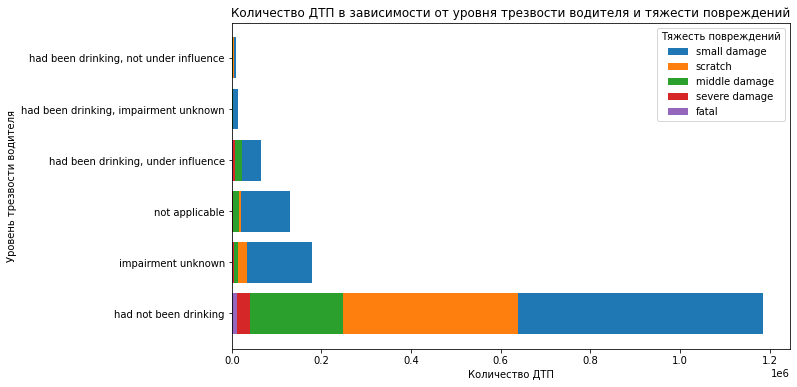

In [11]:
# Анализ зависимости между трезвостью водителя и его участием в ДТП
query = """
SELECT p.party_sobriety, c.collision_damage, COUNT(*) AS accident_count
FROM parties p
JOIN collisions c ON p.case_id = c.case_id
GROUP BY p.party_sobriety, c.collision_damage
ORDER BY accident_count DESC;
"""
sobriety_df = pd.read_sql(query, engine)

# Удалим строки с пропусками
sobriety_df.dropna(subset=['party_sobriety', 'collision_damage'], inplace=True)

# Построение графика
plt.figure(figsize=(10, 6))
for damage_type in sobriety_df['collision_damage'].unique():
    df_subset = sobriety_df[sobriety_df['collision_damage'] == damage_type]
    plt.barh(df_subset['party_sobriety'], df_subset['accident_count'], label=damage_type)

plt.xlabel('Количество ДТП')
plt.ylabel('Уровень трезвости водителя')
plt.title('Количество ДТП в зависимости от уровня трезвости водителя и тяжести повреждений')
plt.legend(title='Тяжесть повреждений')
plt.show()

Большинство ДТП совершают водители, которые не употребляли алкоголь. Это может свидетельствовать о том, что значительное количество аварий происходит из-за других факторов, а не только из-за алкогольного опьянения.

## Создайте модель для оценки водительского риска

In [12]:
# Запрос для получения данных о водителях автомобилей
query = """
SELECT 
    p.at_fault,
    c.collision_date, 
    c.collision_time,
    c.weather_1, 
    c.road_surface, 
    c.lighting, 
    v.vehicle_age, 
    v.vehicle_type, 
    v.vehicle_transmission
FROM 
    parties p
JOIN 
    collisions c ON p.case_id = c.case_id
JOIN 
    vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE 
    p.party_type = 'car'
    AND LOWER(c.collision_damage) != 'scratch'
    AND EXTRACT(YEAR FROM c.collision_date) = 2012;
"""
data_df = pd.read_sql(query, engine)

In [13]:
# Проверка данных
data_df.head()

,at_fault,collision_date,collision_time,weather_1,road_surface,lighting,vehicle_age,vehicle_type,vehicle_transmission
0,0,2012-04-11,14:10:00,cloudy,wet,daylight,3.0,sedan,auto
1,0,2012-01-28,13:50:00,clear,dry,daylight,1.0,sedan,manual
2,0,2012-01-19,16:30:00,clear,dry,daylight,7.0,sedan,manual
3,0,2012-04-13,18:05:00,raining,wet,daylight,4.0,sedan,auto
4,1,2012-05-24,23:52:00,cloudy,dry,dark with street lights,2.0,sedan,manual


In [14]:
# Описание числовых признаков
data_df.describe()

# Описание категориальных признаков
data_df.describe(include=['object'])

,collision_date,collision_time,weather_1,road_surface,lighting,vehicle_type,vehicle_transmission
count,56248,56160,56080,55900,56094,56248,55389
unique,366,1435,7,4,5,3,2
top,2012-03-17,15:00:00,clear,dry,daylight,sedan,manual
freq,571,413,45092,50242,38064,37180,29318


In [15]:
# Преобразование даты 'collision_date'
data_df['collision_month'] = pd.to_datetime(data_df['collision_date']).dt.month
data_df['collision_day'] = pd.to_datetime(data_df['collision_date']).dt.day
data_df['collision_day_of_week'] = pd.to_datetime(data_df['collision_date']).dt.dayofweek

# Преобразование времени 'collision_time'
data_df['collision_hour'] = pd.to_datetime(data_df['collision_time'], format='%H:%M:%S').dt.hour

# Удаляем исходные столбцы с датой и временем, так как они больше не нужны
data_df = data_df.drop(['collision_date', 'collision_time'], axis=1)

In [16]:
# Вычислим корреляционную матрицу PhiK
phik_matrix = data_df.phik_matrix(interval_cols = ['collision_month', 'collision_day', 'collision_day_of_week',\
                                                   'collision_hour', 'vehicle_age'])

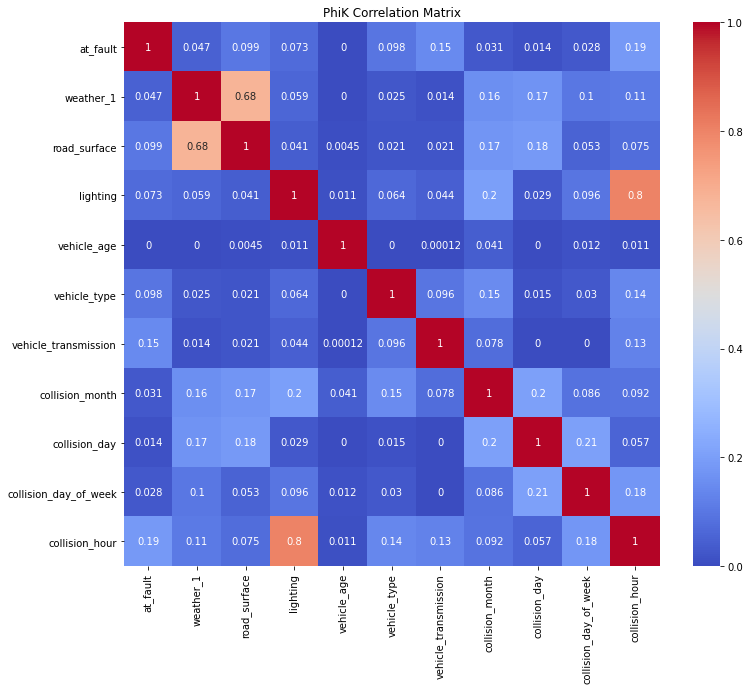

In [17]:
# Отобразим матрицу корреляции с помощью heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
plt.title('PhiK Correlation Matrix')
plt.show()

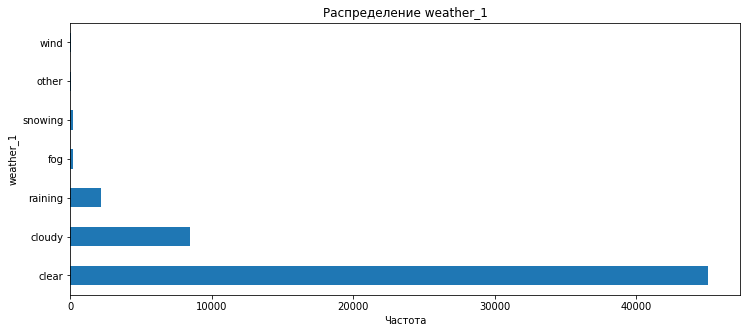

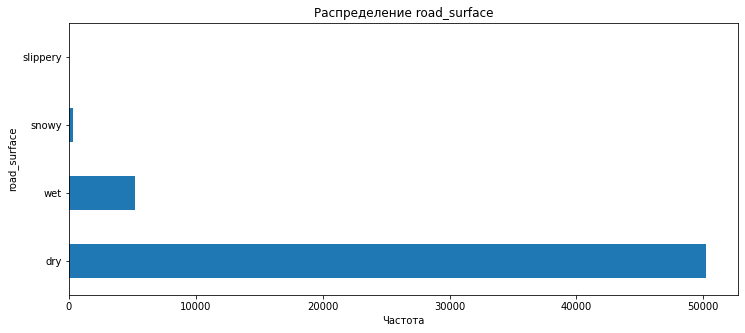

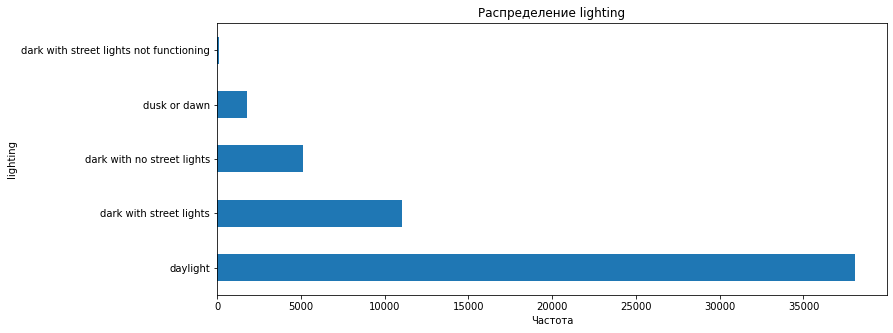

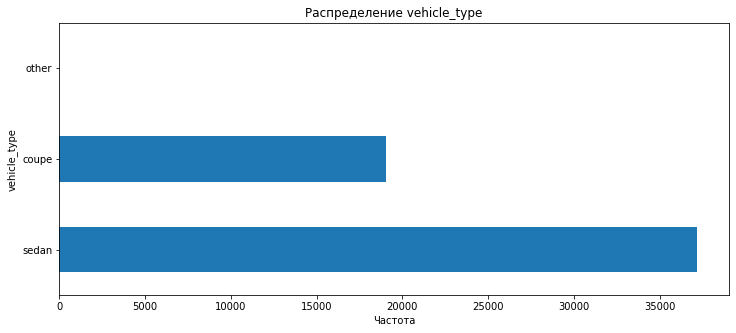

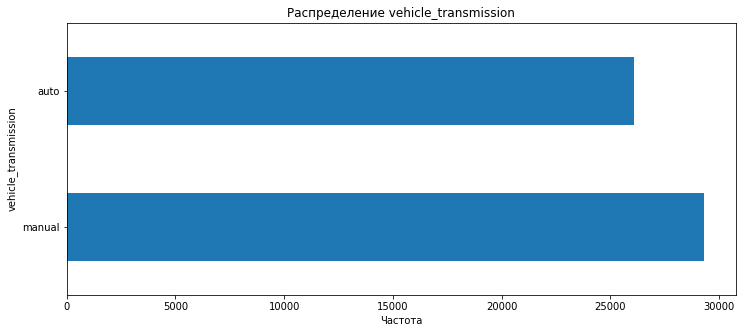

In [18]:
# Построение столбчатых диаграмм для категориальных признаков
for column in ['weather_1', 'road_surface', 'lighting', 'vehicle_type', 'vehicle_transmission']:
    data_df[column].value_counts().plot(kind='barh', figsize=(12, 5))
    plt.title(f'Распределение {column}')  # Заголовок диаграммы
    plt.xlabel('Частота')  # Подпись оси X
    plt.ylabel(column)  # Подпись оси Y (имя признака)
    plt.show()

Наблюдаемый на графиках сильный дисбаланс классов может привести к искажению результатов анализа и снижению точности моделей, обученных на этих данных.

In [19]:
# Определение X и y
X = data_df[['collision_month', 'collision_day', 'collision_day_of_week', 'collision_hour', 'weather_1', 'road_surface', 'lighting', 'vehicle_age',\
            'vehicle_type', 'vehicle_transmission']]
y = data_df['at_fault']  # Целевая переменная

In [20]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
categorical_features = ['weather_1', 'road_surface', 'lighting', 'vehicle_type', 'vehicle_transmission']
numerical_features = ['vehicle_age', 'collision_month', 'collision_day', 'collision_day_of_week', 'collision_hour']

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        # Импутация пропусков для категориальных данных с заполнением наиболее частыми значениями
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
        ]), categorical_features),
        
        # Импутация пропусков для числовых данных
        ('num', SimpleImputer(strategy='mean'), numerical_features)
    ], 
    remainder='passthrough'  # Остальные столбцы пропускаем без изменений
)

In [23]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Если классы сильно несбалансированы, PR AUC будет полезна для оценки модели, так как она фокусируется на положительном классе (высокий риск ДТП).


Оценка модели Logistic Regression на кросс-валидации...
Logistic Regression Средний AUC на кросс-валидации: 0.6294311360422009
Logistic Regression PR AUC на кросс-валидации: 0.6370697022376994

Оценка модели Random Forest на кросс-валидации...
Random Forest Средний AUC на кросс-валидации: 0.6410618875990324
Random Forest PR AUC на кросс-валидации: 0.6448694946145281

Оценка модели Gradient Boosting на кросс-валидации...
Gradient Boosting Средний AUC на кросс-валидации: 0.6516121661712878
Gradient Boosting PR AUC на кросс-валидации: 0.6604576153507203

Лучшая модель на кросс-валидации: Gradient Boosting с AUC = 0.6516121661712878

Оценка лучшей модели Gradient Boosting на тестовой выборке...

Gradient Boosting Classification Report на тестовой выборке:
              precision    recall  f1-score   support

           0       0.59      0.64      0.61      8328
           1       0.62      0.57      0.59      8547

    accuracy                           0.60     16875
   macro avg       

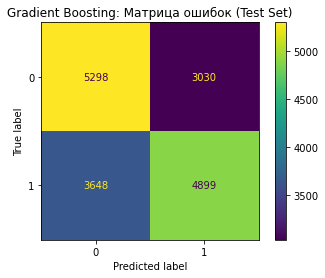

Gradient Boosting PR AUC на тестовой выборке: 0.6578947432239286


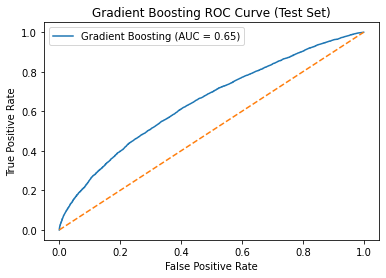

In [24]:
# Функция для оценки модели на кросс-валидации и тестовой выборке
def evaluate_model_cv(model_name, model, X_train, y_train, X_test, y_test, cv=5):
    print(f"\nОценка модели {model_name} на кросс-валидации...")

    # Получение предсказаний на кросс-валидации
    y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)
    y_proba_cv = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

    # Средний AUC на кросс-валидации
    cv_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc').mean()
    print(f"{model_name} Средний AUC на кросс-валидации: {cv_auc}")

    # PR AUC на кросс-валидации
    precision_cv, recall_cv, _ = precision_recall_curve(y_train, y_proba_cv)
    pr_auc_cv = auc(recall_cv, precision_cv)
    print(f"{model_name} PR AUC на кросс-валидации: {pr_auc_cv}")

    return {
        "model_name": model_name,
        "model": model,
        "cv_auc": cv_auc,
        "pr_auc_cv": pr_auc_cv
    }

# Функция для оценки модели на тестовой выборке
def evaluate_best_model_on_test(best_model_info, X_test, y_test):
    model = best_model_info['model']
    model_name = best_model_info['model_name']

    print(f"\nОценка лучшей модели {model_name} на тестовой выборке...")

    # Предсказания на тестовой выборке
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} Classification Report на тестовой выборке:")
    print(classification_report(y_test, y_pred_test))

    # Матрица ошибок
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)
    ConfusionMatrixDisplay(conf_matrix_test).plot()
    plt.title(f'{model_name}: Матрица ошибок (Test Set)')
    plt.show()

    # PR AUC на тестовой выборке
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_proba_test)
    pr_auc_test = auc(recall_test, precision_test)
    print(f"{model_name} PR AUC на тестовой выборке: {pr_auc_test}")

    # ROC AUC на тестовой выборке
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)
    roc_auc_test = roc_auc_score(y_test, y_proba_test)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve (Test Set)')
    plt.legend()
    plt.show()

    # Возвращаем метрики для тестовой выборки
    return {
        "roc_auc_test": roc_auc_test,
        "pr_auc_test": pr_auc_test,
        "confusion_matrix_test": conf_matrix_test
    }

# Оптимизация гиперпараметров для Random Forest
param_dist_rf = {
    'n_estimators': [5, 10],
    'max_depth': [10, 20]
}

# Random Forest с оптимизацией гиперпараметров
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search_rf = GridSearchCV(rf_model, param_grid=param_dist_rf, cv=5, scoring='roc_auc', n_jobs=-1)

# Logistic Regression
pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000, class_weight='balanced',\
                                                                         random_state=42))

# Gradient Boosting
gb_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Оценка нескольких моделей и выбор лучшей на кросс-валидации

# Logistic Regression
logistic_info = evaluate_model_cv("Logistic Regression", pipe, X_train, y_train, X_test, y_test)

# Random Forest (с оптимизацией гиперпараметров)
rf_info = evaluate_model_cv("Random Forest", grid_search_rf, X_train, y_train, X_test, y_test)

# Gradient Boosting
gb_info = evaluate_model_cv("Gradient Boosting", gb_pipeline, X_train, y_train, X_test, y_test)

# Выбор лучшей модели на основе AUC (кросс-валидации)
models_info = [logistic_info, rf_info, gb_info]
best_model_info = max(models_info, key=lambda x: x['cv_auc'])

print(f"\nЛучшая модель на кросс-валидации: {best_model_info['model_name']} с AUC = {best_model_info['cv_auc']}")

# Обучаем лучшую модель на всей обучающей выборке и оцениваем на тестовой выборке
best_model_info['model'].fit(X_train, y_train)

# Оценка лучшей модели на тестовой выборке
test_metrics = evaluate_best_model_on_test(best_model_info, X_test, y_test)

- Полнота для положительного класса составляет 0.58. Это означает, что 42% случаев с реальным риском ДТП остаются нераспознанными. Это может быть критично, особенно если основной целью бизнеса является предотвращение аварий.


- Точность для положительного класса составляет 0.61. Это означает, что 39% предсказанных рисков являются ложными срабатываниями. Ложные срабатывания могут раздражать водителей, но они менее критичны, чем пропуск реальных рисков.

## Проведите анализ важности факторов ДТП

Статистическая сводка для числовых признаков:

In [25]:
data_df.describe()

,at_fault,vehicle_age,collision_month,collision_day,collision_day_of_week,collision_hour
count,56248.000000,54554.000000,56248.000000,56248.000000,56248.000000,56160.000000
mean,0.504427,4.856472,3.233786,15.328314,3.164255,13.318145
std,0.499985,3.234503,1.808481,8.709986,1.969307,5.526344
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,3.000000,2.000000,8.000000,1.000000,10.000000
50%,1.000000,4.000000,3.000000,15.000000,3.000000,14.000000
75%,1.000000,7.000000,4.000000,23.000000,5.000000,17.000000
max,1.000000,161.000000,12.000000,31.000000,6.000000,23.000000


Целевая переменная `at_fault` сбалансирована, так как примерно 50% данных относятся к классу `1` и 50% — к классу `0`, что подтверждается средним значением 0.5044. Признаки, такие как возраст автомобиля и месяц аварии, имеют более широкий диапазон значений, хотя некоторые, например, `collision_day_of_week`, распределены равномерно по дням недели.

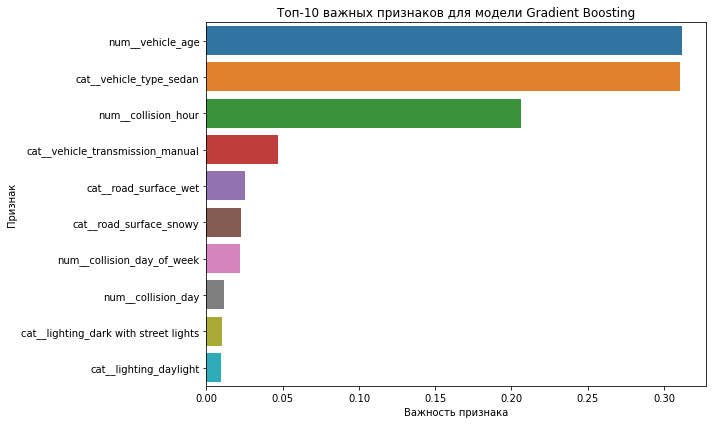

                                  Feature  Importance
20                       num__vehicle_age    0.311728
17                cat__vehicle_type_sedan    0.310705
24                    num__collision_hour    0.206488
18       cat__vehicle_transmission_manual    0.046847
9                   cat__road_surface_wet    0.025469
8                 cat__road_surface_snowy    0.022692
23             num__collision_day_of_week    0.021851
22                     num__collision_day    0.011782
11  cat__lighting_dark with street lights    0.010352
13                 cat__lighting_daylight    0.009225


In [26]:
# Получение имен закодированных и числовых признаков после применения ColumnTransformer
feature_names = preprocessor.get_feature_names_out()

# Получение важности признаков из модели Gradient Boosting
feature_importances = best_model_info['model'].named_steps['classifier'].feature_importances_

# Создание DataFrame для важности признаков
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортировка признаков по важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Визуализация топ-10 признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Топ-10 важных признаков для модели Gradient Boosting')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

# Вывод топ-10 наиболее важных признаков
print(feature_importance_df.head(10))

Тип автомобиля и возраст автомобиля оказались ключевыми факторами для предсказания аварийности в данной модели. Эти признаки могут влиять на маневренность и надёжность автомобиля.
Время суток, особенно отдельные часы, также играет значительную роль в предсказании ДТП, что соответствует представлению о том, что в определённые периоды времени (например, ночью или в часы пик) вероятность аварии выше.
Дорожные условия, особенно мокрая или снежная поверхность, также оказывают влияние на модель, что неудивительно, так как состояние дороги напрямую связано с управляемостью автомобиля и риском аварий.

Остальные признаки являются менее значимыми. Однако важно учитывать, что даже признаки с меньшей важностью могут вносить вклад в предсказательную способность модели.

# Дополнительные факторы, которые могут улучшить модель

## Погодные условия

В дополнение к уже существующему признаку `weather_1`, можно добавить более детализированные погодные факторы, такие как:

1. **Температура**: Влияет на сцепление с дорогой и может быть важным фактором.
2. **Влажность**: Может влиять на видимость или сцепление с дорогой.
3. **Осадки**: Количество осадков (дождь, снег) на момент аварии.

Это позволит модели учитывать не только общее состояние погоды, но и её конкретные аспекты, которые могут способствовать авариям.

---

## Интенсивность движения

1. **Количество машин на дороге**: 
   - В данных можно добавить информацию о плотности трафика на момент аварии. Например, данные о пробках могут быть полезны для анализа.
   
2. **Время суток**: 
   - Включение более детализированной информации о времени аварии может быть важным. Например, разделение дня на временные интервалы (утро, день, вечер, ночь) или учёт "часов пик" может помочь улучшить модель.

---

## Местоположение

### Географические данные:

1. Можно добавить информацию о **географическом месте аварии** (например, город, район, тип дороги). Это может помочь модели учитывать, что аварии могут происходить чаще в определённых местах (например, на перекрёстках, в густонаселённых районах, на трассах).

2. **Тип дороги**: Уточнить информацию о типе дороги (например, автомагистраль, сельская дорога, городской перекрёсток).

---

## Тип аварии

1. **Тип ДТП**: Очень важно учитывать, какой тип ДТП произошёл (лобовое столкновение, столкновение с пешеходом и т.п.). Это может помочь модели различать разные типы аварий и предсказывать их вероятность.
   
2. **Тяжесть аварии**: Включение информации о тяжести аварии (например, с пострадавшими или без) поможет модели лучше понять, какие факторы влияют на серьёзные аварии.

---

## Опыт водителя

1. **Возраст водителя**: Возраст водителя может быть важным фактором, так как молодые и пожилые водители могут иметь разную степень риска участия в ДТП.

2. **Водительский стаж**: Стаж вождения также может быть значимым фактором, так как водители с большим опытом могут быть осторожнее или лучше управлять автомобилем в сложных ситуациях.

---

## Физическое состояние водителя

1. **Усталость водителя**: Возможно, стоит добавить информацию о состоянии водителя в момент аварии (например, был ли он уставшим).

---

## Состояние автомобиля

1. **Техническое состояние автомобиля**: Данные о техническом состоянии автомобиля (например, когда было последнее техобслуживание, состояние шин, тормозов и т.д.) могут быть полезны.

---

## Дополнительные сведения о ДТП

1. **Наличие пассажиров**: Включение информации о количестве пассажиров в автомобиле может быть полезно.
   
2. **Использование средств безопасности**: Признаки, связанные с использованием ремней безопасности, подушек безопасности и прочего, могут улучшить модель.

## Для повышения безопасности и предотвращения ДТП можно оснастить автомобиль следующими современными системами:

1. **Камеры с распознаванием лиц**: Система распознавания лиц обеспечивает автоматическую идентификацию водителя, позволяя настраивать профиль в зависимости от конкретного человека, включая персональные настройки сидений, зеркал и приборной панели. Это также может повысить безопасность, предотвращая несанкционированное использование автомобиля.

2. **Адаптивная система контроля скорости на основе погодных условий**: Используя данные о погоде и состоянии дорожного покрытия, автомобиль может автоматически регулировать максимальную скорость и поведение тормозной системы. В сложных условиях, например, при дожде или снеге, система может предложить водителю снизить скорость или активировать режим повышенной устойчивости.

3. **Интеллектуальная система освещения**: На основе уровня освещенности и времени суток, автомобиль может автоматически настраивать интенсивность и направление света фар. Например, при движении в ночное время или в условиях плохого освещения система может оптимизировать работу фар для максимальной видимости, что снижает риск аварий.

4. **Адаптация к типу автомобиля и трансмиссии**: Автомобиль может быть оснащен системой, которая учитывает особенности типа транспортного средства и его трансмиссии. Например, для внедорожников система может активировать функции помощи при спуске или подъеме, а для автомобилей с механической трансмиссией — напоминать о необходимости переключения передач в зависимости от дорожных условий.

5. **Система предупреждения о столкновениях с учетом времени и дня недели**: В зависимости от времени суток и дня недели, система может предлагать дополнительные предупреждения о возможных рисках. Например, в часы пик система может усиливать мониторинг окружающей среды, предупреждая водителя о потенциально опасных ситуациях.

6. **Умные системы безопасности на основе возраста автомобиля**: Если автомобиль старше определенного срока эксплуатации, система может активировать дополнительные проверки состояния автомобиля, такие как диагностика тормозной системы или системы подвески, чтобы минимизировать риск отказов на дороге.

## Дополнительное исследование зависимости важного фактора vehicle_age и целевой переменной at_fault:

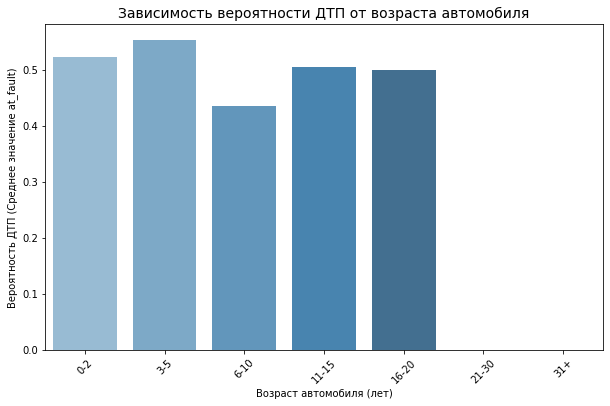

In [31]:
# Создаём интервалы для возраста автомобиля
data_df['vehicle_age_bins'] = pd.cut(data_df['vehicle_age'], bins=[0, 2, 5, 10, 15, 20, 30, 50], labels=['0-2', '3-5', '6-10', '11-15', '16-20', '21-30', '31+'])

# Рассчитываем среднее значение целевой переменной для каждого интервала возраста автомобиля
age_fault = data_df.groupby('vehicle_age_bins')['at_fault'].mean().reset_index()

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x='vehicle_age_bins', y='at_fault', data=age_fault, palette='Blues_d')
plt.title('Зависимость вероятности ДТП от возраста автомобиля', fontsize=14)
plt.xlabel('Возраст автомобиля (лет)')
plt.ylabel('Вероятность ДТП (Среднее значение at_fault)')
plt.xticks(rotation=45)
plt.show()

## Выводы:
- Наибольший риск ДТП наблюдается у автомобилей возрастом 3-5 лет. Это может быть связано с активной эксплуатацией, но без должного технического обслуживания.
- Наименьший риск ДТП наблюдается у автомобилей, которым от 6 до 10 лет, что может говорить о том, что водители начинают более тщательно следить за техническим состоянием своих автомобилей, а также обретать опыт вождения.
- Старые автомобили (более 10 лет) имеют повышенный риск ДТП, что может быть связано с ухудшением их технического состояния и снижением надёжности.

### Для учёта возраста автомобиля и минимизации рисков во время посадки водителя можно оборудовать автомобиль следующими системами:

- Система мониторинга технического состояния для своевременного предупреждения о неисправностях.
- Системы помощи водителю, такие как экстренное торможение, контроль полосы и мониторинг слепых зон.
- Электронные системы стабилизации и контроля тяги, которые помогут удерживать управление при сложных условиях.
- Уведомления о возрасте автомобиля и рекомендация водителю о необходимости соблюдать осторожность.

## Выводы

Лучшей моделью оказалась Gradient Boosting. Создание адекватной системы оценки риска при выдаче авто возможно. При выдаче авто необходимо проверять уровень трезвости водителя.